<a href="https://colab.research.google.com/github/profsuccodifrutta/ai_act_RAG_navigator/blob/main/ai_act_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CREATION OF ENVIORMENT**

In [1]:
# install uv
!curl -LsSf https://astral.sh/uv/install.sh | sh
import sys
import os
from google.colab import userdata
sys.path.append("/root/.cargo/bin")

# configuratrion github with secrets
GIT_USER = "profsuccodifrutta"
GIT_REPO = "ai_act_RAG_navigator"

try:
    GIT_TOKEN = userdata.get('github_token')
except Exception:
    print("ERROR")
    sys.exit(1)

# clone repo
if not os.path.exists(GIT_REPO):
    !git clone https://{GIT_TOKEN}@github.com/{GIT_USER}/{GIT_REPO}.git
else:
    print(f"folder {GIT_REPO} already exists.")

%cd {GIT_REPO}

!git remote set-url origin https://{GIT_TOKEN}@github.com/{GIT_USER}/{GIT_REPO}.git

if not os.path.exists("pyproject.toml"):
    !uv init
else:
    print("uv already initialized.")

# add libraries
!uv add langchain langchain-community langchain-google-genai faiss-cpu pymupdf spacy python-dotenv
!uv add langchain-text-splitters langchain-core
!uv pip install --system langchain-text-splitters langchain-core
# install on colab
!uv pip install --system langchain langchain-community langchain-google-genai faiss-cpu pymupdf spacy python-dotenv

print("\nEnviorment configuration completed")

downloading uv 0.10.4 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!
Cloning into 'ai_act_RAG_navigator'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 50 (delta 22), reused 12 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 2.29 MiB | 16.40 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/ai_act_RAG_navigator
uv already initialized.
Using CPython 3.12.12 interpreter at: /usr/bin/python3
Creating virtual environment at: .venv
Resolved 99 packages in 4ms
Prepared 97 packages in 11.49s
Installed 97 packages in 427ms
 + aiohappyeyeballs==2.6.1
 + aiohttp==3.13.3
 + aiosignal==1.4.0
 + annotated-doc==0.0.4
 + annotated-types==0.7.0
 + anyio==4.12.1
 + attrs==25.4.0
 + blis==1.3.3
 + catalogue==2.0.10
 + certifi==2026.1.4
 + cffi==2.0.0
 + charset-normalizer==3.4.4
 + click==8.3.1
 + cloudpathli

In [2]:
# configuration
!git config --global user.email "matteo@drezzo.ch"
!git config --global user.name "profsuccodifrutta"
!git branch -M main

**PRE-PROCESSING**

In [14]:
from google.colab import drive
import os
import requests
import shutil
import fitz
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import gc
import random
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy import displacy
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
import plotly.graph_objects as go
from collections import Counter

Creates a local data/ directory within the repository, and loads the official 144-page EU AI Act PDF. It also prepares a dedicated folder on Drive to store the future FAISS vector index

In [4]:
drive.mount('/content/drive')

# local env set up
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Folder '{data_dir}' created.")

# path configuration
drive_pdf_path = "/content/drive/MyDrive/compliance_and_regulation_rag/regulation_pdfs/ai_act_2024.pdf"

local_pdf_path = os.path.join(data_dir, "eu_ai_act.pdf") # local destination

# Copy file from Drive to Local Data folder
if os.path.exists(drive_pdf_path):
    shutil.copy(drive_pdf_path, local_pdf_path)
    print(f"File copied from Drive to: {local_pdf_path} ({os.path.getsize(local_pdf_path)} bytes)")
else:
    print(f"Error: File NOT found on Drive at {drive_pdf_path}")

# persistence folder for FAISS index
drive_persistence_path = "/content/drive/MyDrive/compliance_and_regulation_rag/ai_act_rag_index"
if not os.path.exists(drive_persistence_path):
    os.makedirs(drive_persistence_path)
    print("Folder for index persistence ready on Drive.")

Mounted at /content/drive
File copied from Drive to: data/eu_ai_act.pdf (2583319 bytes)


The parse_ai_act_robust() function acts as a highly specialized document parser designed to extract the EU AI Act into clean, semantically isolated legal units. First, it reads the PDF page by page, stripping away formatting noise like document links, page numbers, and line-break hyphens. It employs a multiline regex strategy to detect and truncate footnote blocks at the bottom of the pages; this prevents those footnotes from being falsely extracted as standalone Recitals or corrupting the flow of the main text. After sanitizing the pages, it groups them into "RECITAL", "ARTICLE", and "ANNEX" buckets based on their structural locations in the document. Finally, it stitches the text back together and uses strict, newline-aware regular expressions to split the document only at true section headers, entirely ignoring inline cross-references (like "in accordance with Article 99"). This guarantees that every row in the resulting dataframe represents a single, complete, and unbroken legal concept perfectly for a RAG system.

In [5]:
def parse_ai_act_robust(pdf_path):
    doc = fitz.open(pdf_path)

    categories_text = {
        "RECITAL": [],
        "ARTICLE": [],
        "ANNEX": []
    }

    noise_pattern = re.compile(r"(\d+/144|ELI: http://data\.europa\.eu/eli/reg/.+|OJ L, 12\.7\.2024|EN|\(Text with EEA relevance\))")
    footnote_cleaner = re.compile(r"\n\s*\(\s*\d+\s*\)\s*(?:OJ\b|Position\b|Directive\b|Regulation\b|See\b|Case\b).*$", re.IGNORECASE | re.DOTALL)

    print("Reading PDF and filtering noise & footnotes...")
    footnotes_removed = 0

    for page_num in range(len(doc)):
        text = doc[page_num].get_text("text").replace("-\n", "")

        clean_lines = []
        for line in text.split("\n"):
            cleaned_line = noise_pattern.sub("", line).strip()
            if cleaned_line and not cleaned_line.isdigit():
                clean_lines.append(cleaned_line)

        # Join the page back together
        final_page_text = "\n" + "\n".join(clean_lines)

        if footnote_cleaner.search(final_page_text):
            # Replace the footnote block with a single newline
            final_page_text = footnote_cleaner.sub("\n", final_page_text)
            footnotes_removed += 1

        p_idx = page_num + 1
        if p_idx < 44:
            categories_text["RECITAL"].append(final_page_text)
        elif 44 <= p_idx <= 123:
            categories_text["ARTICLE"].append(final_page_text)
        else:
            categories_text["ANNEX"].append(final_page_text)

    doc.close()
    print(f"Success: Removed footnote blocks from {footnotes_removed} pages.")

    units = []

    # proces recitals
    recital_text = "\n" + "\n".join(categories_text["RECITAL"]) + "\n"
    rec_parts = re.split(r"\n\s*\(\s*(\d+)\s*\)\s+", recital_text)
    for i in range(1, len(rec_parts), 2):
        text_content = rec_parts[i+1].replace("\n", " ").strip()
        if text_content:
            units.append({"id": f"RECITAL {rec_parts[i]}", "category": "RECITAL", "text": text_content})

    # proces articles
    article_text = "\n" + "\n".join(categories_text["ARTICLE"]) + "\n"
    art_parts = re.split(r"(?i)\n\s*Article\s+(\d+)\s*\n", article_text)
    for i in range(1, len(art_parts), 2):
        text_content = art_parts[i+1].replace("\n", " ").strip()
        if text_content:
            units.append({"id": f"ARTICLE {art_parts[i]}", "category": "ARTICLE", "text": text_content})

    # proces annexes
    annex_text = "\n" + "\n".join(categories_text["ANNEX"]) + "\n"
    annex_parts = re.split(r"(?i)\n\s*ANNEX\s+([IVXLCDM]+)\s*\n", annex_text)
    for i in range(1, len(annex_parts), 2):
        text_content = annex_parts[i+1].replace("\n", " ").strip()
        if text_content:
            units.append({"id": f"ANNEX {annex_parts[i].upper()}", "category": "ANNEX", "text": text_content})

    return pd.DataFrame(units)

In [6]:
df_units = parse_ai_act_robust(local_pdf_path)
df_units['len'] = df_units['text'].str.len()

print(f"Clean Units created: {len(df_units)}")
print(f"Max length: {df_units['len'].max()}")

Reading PDF and filtering noise & footnotes...
Success: Removed footnote blocks from 23 pages.
Clean Units created: 307
Max length: 17095


**CHUNK ANALYSIS**

An embedding vector represents the "average" meaning of a text. If a chunk is too long and covers five different legal requirements, the vector becomes vague, making it harder for the system to find that specific information during a search. Even if an LLM can read a huge chunk, providing too much irrelevant text alongside the answer creates "noise." This increases the risk of the model hallucinating or missing the specific detail you're looking for.

In [20]:
import plotly.graph_objects as go

avg_len = df_units['len'].mean()

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df_units['len'],
    nbinsx=50,
    marker_color='#e74c3c',
    marker_line=dict(color='white', width=1),
    name='Unit Lengths'
))

fig.add_vline(x=1500, line_dash="dash", line_color="#c0392b")

fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='lines',
    line=dict(color='#c0392b', dash='dash'),
    name='Target RAG Limit (1500)'
))

fig.add_vline(x=avg_len, line_dash="solid", line_color="#f39c12")

fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='lines',
    line=dict(color='#f39c12', shape='linear'),
    name=f'Average Length ({avg_len:.0f})'
))

fig.update_layout(
    title='<b>Distribution of Legal Unit Lengths </b>',
    xaxis_title="Characters",
    yaxis_title="Number of Units",
    template='plotly_white',
    bargap=0.05,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor="rgba(255, 255, 255, 0.5)"
    ),
    height=500
)

fig.show()

RecursiveCharacterTextSplitter() slices the text into chunks of up to 1500 characters, maintaining a 200-character overlap to ensure no nuanced legal context is lost at the boundaries. It applies "contextual chunking" by prepending the exact legal identifier (such as [ARTICLE 10]) directly into the text of every single slice, this guarantees that the LLM always knows exactly which part of the law it is referencing. Then it packages each segment into a LangChain Document object and enriches it with highly structured metadata, including the category, legal unit, and a flag indicating if it is a continuation resulting in a robust, searchable dataset ready for embedding into the FAISS vector database.

In [8]:
# 1500 chars with 200 overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
    length_function=len,
    separators=["\n\n", "\n", ".", " ", ""]
)

final_documents = []

for _, row in df_units.iterrows():
    unit_id = row['id']
    category = row['category']
    text = row['text']

    chunks = text_splitter.split_text(text)

    for i, chunk in enumerate(chunks):
        enriched_content = f"[{unit_id}] {chunk}"
        doc = Document(
            page_content=enriched_content,
            metadata={
                "source": "EU_AI_Act_2024",
                "category": category,
                "legal_unit": unit_id,
                "chunk_index": i,
                "is_continuation": i > 0
            }
        )
        final_documents.append(doc)

print(f"Total vectorized chunks ready for FAISS: {len(final_documents)}")

Total vectorized chunks ready for FAISS: 577


An additional refinement step was implemented to optimize the dataset for the Retrieval-Augmented Generation architecture. Following the initial text splitting, a filtering mechanism was applied to remove 7 low-value, boilerplate chunks, specifically legislative preambles and fragmented text containing fewer than 100 characters. Addiotionaly, leading punctuation artifacts generated by the recursive splitting process were stripped. This reduction from 577 to 570 highly concentrated text chunks ensures the FAISS vector database is populated exclusively with semantically dense legal provisions. By eliminating contextual noise, this approach maximizes embedding precision, reduces retrieval latency, and mitigates the risk of LLM hallucinations during the generation phase.

In [24]:
polished_documents = []

for doc in final_documents:
    clean_text = re.sub(r"^(\[.*?\])\s*[,.]+\s*", r"\1 ", doc.page_content)

    if len(clean_text) > 100:
        doc.page_content = clean_text # update document with cleaned text
        polished_documents.append(doc)

print(f"Original chunks: {len(final_documents)}")
print(f"Polished chunks ready for vectorization: {len(polished_documents)}")
print(f"Removed {len(final_documents) - len(polished_documents)} low-value/boilerplate chunks.")

chunk_lengths = [len(doc.page_content) for doc in polished_documents]

Original chunks: 577
Polished chunks ready for vectorization: 570
Removed 7 low-value/boilerplate chunks.


In [ ]:
num_chunks_to_check = 4

random_chunks = random.sample(polished_documents, num_chunks_to_check)

print("=== 4 RANDOM HIGH-QUALITY CHUNKS ===\n")

for i, doc in enumerate(random_chunks):
    print(f"RANDOM CHUNK {i+1}")
    print(f"Metadata: {doc.metadata}")
    print(f"Length: {len(doc.page_content)} characters")
    print(f"Text Preview: {doc.page_content[:800]}...\n")  # Previewing 800 characters
    print("-" * 50 + "\n")

=== 4 RANDOM HIGH-QUALITY CHUNKS ===

RANDOM CHUNK 1
Metadata: {'source': 'EU_AI_Act_2024', 'category': 'ARTICLE', 'legal_unit': 'ARTICLE 9', 'chunk_index': 2, 'is_continuation': True}
Length: 1388 characters
Text Preview: [ARTICLE 9] 6. High-risk AI systems shall be tested for the purpose of identifying the most appropriate and targeted risk management measures. Testing shall ensure that high-risk AI systems perform consistently for their intended purpose and that they are in compliance with the requirements set out in this Section. 7. Testing procedures may include testing in real-world conditions in accordance with Article 60. 8. The testing of high-risk AI systems shall be performed, as appropriate, at any time throughout the development process, and, in any event, prior to their being placed on the market or put into service. Testing shall be carried out against prior defined metrics and probabilistic thresholds that are appropriate to the intended purpose of the high-risk AI syst

In [23]:
avg_len = sum(chunk_lengths) / len(chunk_lengths) if chunk_lengths else 0

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=chunk_lengths,
    nbinsx=50,
    marker_color='#e74c3c',
    marker_line=dict(color='white', width=1),
    name='Chunk Lengths'
))

fig.add_vline(x=1500, line_dash="dash", line_color="#c0392b")

fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='lines',
    line=dict(color='#c0392b', dash='dash'),
    name='Max Chunk Limit (1500)'
))

fig.add_vline(x=avg_len, line_dash="solid", line_color="#f39c12")


fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='lines',
    line=dict(color='#f39c12'),
    name=f'Average Length ({avg_len:.0f})'
))

fig.update_layout(
    title='<b>Distribution of Final Vectorized Chunk Lengths</b>',
    xaxis_title="Characters per Chunk",
    yaxis_title="Number of Chunks",
    template='plotly_white',
    bargap=0.05,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.5)"
    ),
    height=500
)

fig.show()

Below is shown a barplot of the absolute count of chunks belonging to RECITAL, ARTICLE, and ANNEX. This proves that the dataset is heavily weighted toward operative legal text (Articles) but retains the contextual intent (Recitals).

In [13]:
categories = [doc.metadata['category'] for doc in polished_documents]
category_counts = Counter(categories)
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)

labels = [x[0] for x in sorted_categories]
values = [x[1] for x in sorted_categories]

fig = go.Figure(data=[
    go.Bar(
        x=labels,
        y=values,
        text=values,
        textposition='auto',
        marker=dict(
            color=values,
            colorscale=[
                [0, '#ffcccc'],
                [1, '#b30000']
            ],
            showscale=False,
            line=dict(color='white', width=1.5)
        )
    )
])

fig.update_layout(
    title='<b>Document Structural Balance</b><br><sup>Chunks per Category</sup>',
    xaxis_title="Category",
    yaxis_title="Number of Vectorized Chunks",
    template='plotly_white',
    font=dict(family="Arial", size=12),
    bargap=0.2,
    height=500
)

fig.show()

**TF-IDF exploratory analysis**


The TF-IDF approach is an essential exploratory tool for text mining because it goes far beyond simple word counts, which can often be misleading. TF-IDF evaluates the importance of a word by balancing its local frequency within a specific chunk against its global rarity across the entire dataset.  It deliberately penalizes common words that appear everywhere and assigns greater weight to terms that uniquely characterize individual documents. This mathematical filtering ensures that words with higher TF-IDF scores genuinely represent the most significant and meaningful concepts of the text.

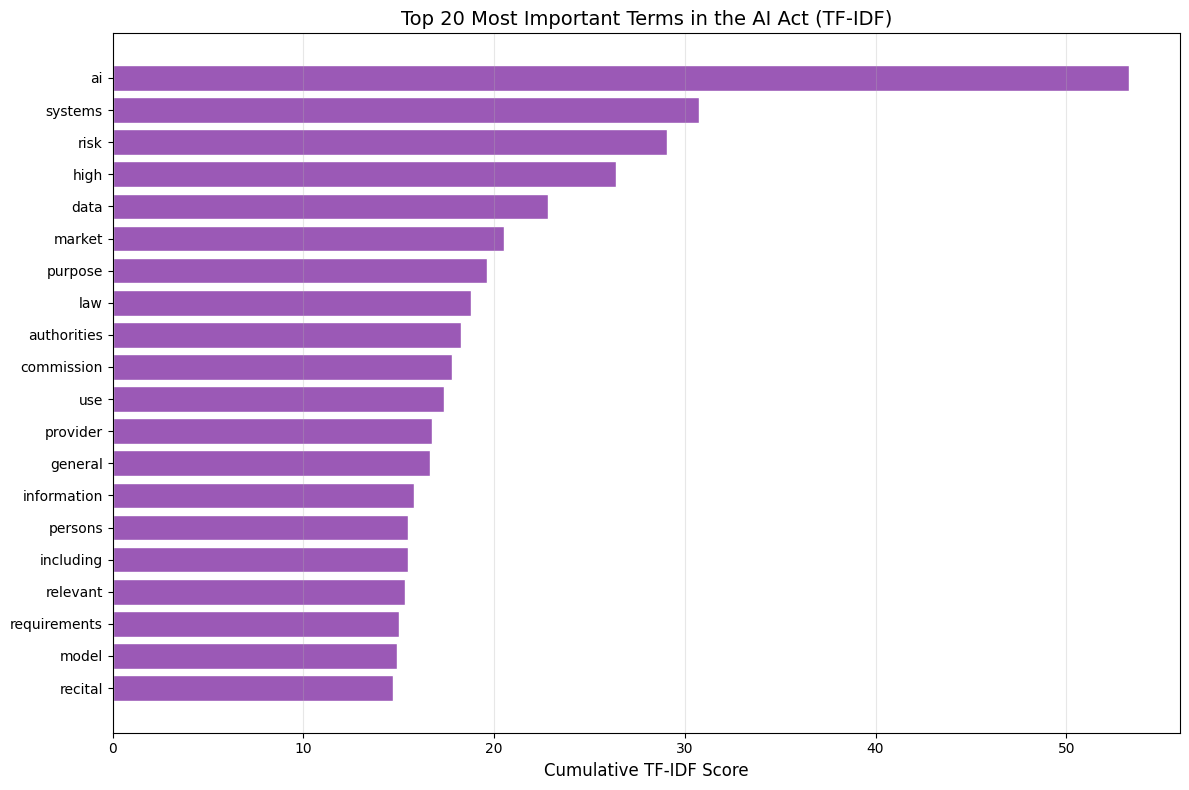

In [ ]:
# Extract the raw text from all polished chunks
corpus = [doc.page_content for doc in polished_documents]

custom_stop_words = ['shall', 'article', 'regulation', 'paragraph', 'annex',
                     'member', 'states', 'union', 'eu', 'referred', 'accordance', 'chapter']
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
all_stop_words = list(ENGLISH_STOP_WORDS) + custom_stop_words

vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_features=1000)
tfidf_matrix = vectorizer.fit_transform(corpus)

# Sum the TF-IDF scores for each word across the entire dataset
word_scores = tfidf_matrix.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# sort by the highest scoring words
df_words = pd.DataFrame({'word': words, 'score': word_scores})
top_20_words = df_words.sort_values(by='score', ascending=False).head(20)

top_20_words = top_20_words.sort_values(by='score', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(top_20_words['word'], top_20_words['score'], color='#9b59b6', edgecolor='white')
plt.title('Top 20 Most Important Terms in the AI Act (TF-IDF)', fontsize=14)
plt.xlabel('Cumulative TF-IDF Score', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**NER FOR ENRICHING THE METADATA**


In a standard RAG system, the database relies entirely on dense vector embeddings to find relevant information. While vectors are excellent at understanding the semantic meaning or general theme of a question, they struggle significantly with exact keyword matching. For example, a vector search might easily confuse the legal obligations of a "Provider" with those of a "Deployer" because both concepts occupy a very similar mathematical space in the vector database.

**ERROR ANALYSIS METHODOLOGY**


Identifying and extracting these entities requires an iterative methodology known as Error Analysis, as relying entirely on pre-trained machine learning models for domain-specific legal text will lead to systemic failures. Pre-trained NLP models calculate statistical probabilities based on everyday internet text; they get easily confused by the dense capitalization, roman numerals, and acronyms found in the AI Act.

To overcome this, we established an iterative feedback loop:


1.   Baseline Definition: We injected a baseline set of deterministic rules (the EntityRuler) into the pipeline before the machine learning component.
2.   Visual Diagnostics: We ran random samples of the text through the pipeline and used a visualizer (displaCy) to inspect the model's behavior.
3. Identifying False Positives & Negatives: By reading the annotated text, we spotted areas where the model missed critical terms.
4. Rule Calibration: We updated our deterministic rules to either explicitly classify these edge cases (e.g. assigning "Annexes" to DOCUMENT)


The rules that drive this extraction are defined in a simple but highly powerful Python list called patterns. Every rule is a dictionary containing two key-value pairs: the "label" (which dictates the category, like "ORG" or "RISK_LEVEL") and the "pattern" (which defines what text to look for).

In [ ]:
nlp = spacy.load("en_core_web_sm")

ruler = nlp.add_pipe("entity_ruler", before="ner")

patterns = [
# --- ORGANIZATIONS & AUTHORITIES ---
    {"label": "ORG", "pattern": "AI Office"},
    {"label": "ORG", "pattern": "European Artificial Intelligence Board"},
    {"label": "ORG", "pattern": "Market Surveillance Authority"},
    {"label": "ORG", "pattern": [{"lower": "european"}, {"lower": "commission"}]},

    # fix Entity Fragmentation for Data Protection bodies
    {"label": "ORG", "pattern": "European Data Protection Board"},
    {"label": "ORG", "pattern": "European Data Protection Supervisor"},
    {"label": "ORG", "pattern": "EDPB"},
    {"label": "ORG", "pattern": "EDPS"},

    # NEW: Legal Shorthands (Case-sensitive because they are Proper Nouns in the text)
    {"label": "ORG", "pattern": "Board"},
    {"label": "ORG", "pattern": "Commission"},

    # GEOPOLITICAL ENTITIES
    {"label": "GPE", "pattern": "Union"},
    {"label": "GPE", "pattern": "EU"},

    # STRUCTURAL LEGAL ELEMENTS
    {"label": "DOCUMENT", "pattern": "Regulation"},
    {"label": "DOCUMENT", "pattern": "Directive"},
    {"label": "DOCUMENT", "pattern": [{"lower": "annex"}, {"IS_ALPHA": True, "IS_UPPER": True}]},
    {"label": "DOCUMENT", "pattern": [{"lower": "annexes"}, {"IS_ALPHA": True, "IS_UPPER": True}]},

    # Chapters (Catches both "Chapter 3" and "Chapter III")
    {"label": "LAW", "pattern": [{"lower": "chapter"}, {"IS_DIGIT": True}]},
    {"label": "LAW", "pattern": [{"lower": "chapter"}, {"IS_ALPHA": True, "IS_UPPER": True}]},

    # Sections (Catches both "Section 2" and "Section IV")
    {"label": "LAW", "pattern": [{"lower": "section"}, {"IS_DIGIT": True}]},
    {"label": "LAW", "pattern": [{"lower": "section"}, {"IS_ALPHA": True, "IS_UPPER": True}]},
    {"label": "LAW", "pattern": [{"lower": "sections"}, {"IS_DIGIT": True}]},
    {"label": "LAW", "pattern": [{"lower": "sections"}, {"IS_ALPHA": True, "IS_UPPER": True}]},

    # Articles
    {"label": "LAW", "pattern": [{"lower": "article"}, {"IS_DIGIT": True}]},

    # Domain Stop Words
    {"label": "IGNORE", "pattern": "AI"},
    {"label": "IGNORE", "pattern": [{"lower": "artificial"}, {"lower": "intelligence"}]},
    {"label": "IGNORE", "pattern": [{"lower": "ai"}, {"lower": "system"}]},

    # CONCEPTS, LEGAL ROLES and RISK LEVELS
    {"label": "CONCEPT", "pattern": "CE"},
    {"label": "CONCEPT", "pattern": [{"text": "CE"}, {"lower": "marking"}]},
    {"label": "CONCEPT", "pattern": [{"lower": "general"}, {"IS_PUNCT": True, "OP": "?"}, {"lower": "purpose"}, {"lower": "ai"}]},
    {"label": "LEGAL_ROLE", "pattern": [{"lower": "provider"}]},
    {"label": "LEGAL_ROLE", "pattern": [{"lower": "providers"}]},
    {"label": "LEGAL_ROLE", "pattern": [{"lower": "deployer"}]},
    {"label": "LEGAL_ROLE", "pattern": [{"lower": "deployers"}]},
    {"label": "RISK_LEVEL", "pattern": [{"lower": "high"}, {"IS_PUNCT": True, "OP": "?"}, {"lower": "risk"}]},
    {"label": "RISK_LEVEL", "pattern": [{"lower": "unacceptable"}, {"lower": "risk"}]}
]

ruler.add_patterns(patterns)


sample_chunks = random.sample(polished_documents, 3)

for i, doc in enumerate(sample_chunks):
    print(f"\n--- CHUNK {i+1} (Source: {doc.metadata['legal_unit']}) ---")
    spacy_doc = nlp(doc.page_content)

    custom_colors = {
        "LEGAL_ROLE": "linear-gradient(90deg, #f1c40f, #f39c12)",
        "RISK_LEVEL": "linear-gradient(90deg, #e74c3c, #c0392b)",
        "CONCEPT": "linear-gradient(90deg, #3498db, #2980b9)",
        "DOCUMENT": "linear-gradient(90deg, #9b59b6, #8e44ad)",
        "LAW": "linear-gradient(90deg, #34495e, #2c3e50)",
        "GPE": "linear-gradient(90deg, #2ecc71, #27ae60)"
    }

    #  hides the 'IGNORE' tags
    visible_ents = ["ORG", "GPE", "DOCUMENT", "LAW", "CONCEPT", "LEGAL_ROLE", "RISK_LEVEL"]

    options = {
        "colors": custom_colors,
        "ents": visible_ents
    }

    displacy.render(spacy_doc, style="ent", jupyter=True, options=options)


--- CHUNK 1 (Source: ARTICLE 36) ---



--- CHUNK 2 (Source: ARTICLE 41) ---



--- CHUNK 3 (Source: RECITAL 67) ---


LangChain wraps every chunk of the text into a specific Python object called a Document, it has exactly two parts:


1.   page_content: A single string of text
2.   metadata: A standard Python Dictionary

to add a brand new piece of information, simply invent a new key and assign it a value (my_dict["new_invented_key"] = "new value!")


The true metadata enrichement happens here:

In [ ]:
for doc in polished_documents:

    spacy_doc = nlp(doc.page_content)

    #  sets {} to collect unique entities found in this specific chunk
    extracted = {
        "organizations": set(),
        "geopolitical": set(),
        "documents": set(),
        "laws": set(),
        "concepts": set(),
        "legal_roles": set(),
        "risk_levels": set()
    }

    # categorize the extracted entities
    for ent in spacy_doc.ents:
        if ent.label_ == "ORG": extracted["organizations"].add(ent.text)
        elif ent.label_ == "GPE": extracted["geopolitical"].add(ent.text)
        elif ent.label_ == "DOCUMENT": extracted["documents"].add(ent.text)
        elif ent.label_ == "LAW": extracted["laws"].add(ent.text)
        elif ent.label_ == "CONCEPT": extracted["concepts"].add(ent.text)
        elif ent.label_ == "LEGAL_ROLE": extracted["legal_roles"].add(ent.text)
        elif ent.label_ == "RISK_LEVEL": extracted["risk_levels"].add(ent.text)

    # inject these as new keys in the document's metadata dictionary
    doc.metadata["ner_organizations"] = list(extracted["organizations"]) # to list since faiss need standard array formats
    doc.metadata["ner_geopolitical"] = list(extracted["geopolitical"])
    doc.metadata["ner_documents"] = list(extracted["documents"])
    doc.metadata["ner_laws"] = list(extracted["laws"])
    doc.metadata["ner_concepts"] = list(extracted["concepts"])
    doc.metadata["ner_legal_roles"] = list(extracted["legal_roles"])
    doc.metadata["ner_risk_levels"] = list(extracted["risk_levels"])


sample_doc = random.choice(polished_documents)

print("\n=== METADATA VERIFICATION ===")
print(f"Legal Unit: {sample_doc.metadata['legal_unit']}")
print(f"Text Preview: {sample_doc.page_content[:150]}...")
print("\nInjected NER Metadata:")
print(f"- Organizations: {sample_doc.metadata['ner_organizations']}")
print(f"- Legal Roles: {sample_doc.metadata['ner_legal_roles']}")
print(f"- Risk Levels: {sample_doc.metadata['ner_risk_levels']}")
print(f"- Concepts: {sample_doc.metadata['ner_concepts']}")
print(f"- Laws: {sample_doc.metadata['ner_laws']}")
print(f"- Documents: {sample_doc.metadata['ner_documents']}")
print(f"- Geopolitical: {sample_doc.metadata['ner_geopolitical']}")


=== METADATA VERIFICATION ===
Legal Unit: RECITAL 103
Text Preview: [RECITAL 103] Free and open-source AI components covers the software and data, including models and general-purpose AI models, tools, services or proc...

Injected NER Metadata:
- Organizations: []
- Legal Roles: []
- Risk Levels: []
- Concepts: ['general-purpose AI']
- Laws: []
- Documents: ['Regulation']
- Geopolitical: []


**EMBEDDDING THE CHUNKS AND CREATION OF DATABASE**

In [ ]:
!pip install sentence-transformers faiss-cpu

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

hf_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}
)
print("Model loaded")

print(f"Embedding {len(polished_documents)} chunks. This will take a moment...")

vectorstore = FAISS.from_documents(polished_documents, hf_embeddings) # text to gpu, vectorizes, and organizes in FAISS index
print("FAISS index built")

vectorstore.save_local(drive_persistence_path)

print("\n Vector database created and saved")

**RETRIVAL**

In [ ]:
hf_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}
)


vectorstore = FAISS.load_local(
    folder_path=drive_persistence_path,
    embeddings=hf_embeddings,
    allow_dangerous_deserialization=True
)
print("Database loaded")

In [ ]:
query = "What are the rules and obligations for high-risk biometric identification systems?"
print(f"User Question: '{query}'\n")

k = 3
top_chunks = vectorstore.similarity_search(query, k=k)

print("=== RETRIEVAL RESULTS ===\n")
for i, chunk in enumerate(top_chunks):
    print(f"--- RESULT {i+1} ---")
    print(f"Legal Unit: {chunk.metadata.get('legal_unit', 'Unknown')}")
    print(f"Text Preview: {chunk.page_content[:250]}...\n")

    print(f"Detected Entities in this chunk:")
    print(f" - Risk Levels: {chunk.metadata.get('ner_risk_levels', [])}")
    print(f" - Concepts: {chunk.metadata.get('ner_concepts', [])}")
    print(f" - Legal Roles: {chunk.metadata.get('ner_legal_roles', [])}\n")

User Question: 'What are the rules and obligations for high-risk biometric identification systems?'

=== RETRIEVAL RESULTS ===

--- RESULT 1 ---
Legal Unit: RECITAL 54
Text Preview: [RECITAL 54] As biometric data constitutes a special category of personal data, it is appropriate to classify as high-risk several critical-use cases of biometric systems, insofar as their use is permitted under relevant Union and national law. Techn...

Detected Entities in this chunk:
 - Risk Levels: ['high-risk']
 - Concepts: []
 - Legal Roles: []

--- RESULT 2 ---
Legal Unit: ARTICLE 26
Text Preview: [ARTICLE 26] 8. Deployers of high-risk AI systems that are public authorities, or Union institutions, bodies, offices or agencies shall comply with the registration obligations referred to in Article 49. When such deployers find that the high-risk AI...

Detected Entities in this chunk:
 - Risk Levels: ['high-risk']
 - Concepts: []
 - Legal Roles: ['Deployers', 'provider', 'deployers', 'deployer']

--- RESU

**HYBRID SEARCH**

In [ ]:
print("\n=== HYBRID SEARCH ===")

query = "What are the registration obligations for high-risk biometric systems?"

filter_function = lambda metadata: any(
    "deployer" in role.lower() for role in metadata.get("ner_legal_roles", [])
)

filtered_chunks = vectorstore.similarity_search(
    query,
    k=3,
    filter=filter_function
)

if not filtered_chunks:
    print("No chunks found")

for i, chunk in enumerate(filtered_chunks):
    print(f"\n--- FILTERED RESULT {i+1} ---")
    print(f"Legal Unit: {chunk.metadata.get('legal_unit', 'Unknown')}")
    print(f"Legal Roles: {chunk.metadata.get('ner_legal_roles', [])}")
    print(f"Text Preview: {chunk.page_content[:200]}...\n")


=== HYBRID SEARCH ===

--- FILTERED RESULT 1 ---
Legal Unit: ARTICLE 26
Legal Roles: ['Deployers', 'provider', 'deployers', 'deployer']
Text Preview: [ARTICLE 26] 8. Deployers of high-risk AI systems that are public authorities, or Union institutions, bodies, offices or agencies shall comply with the registration obligations referred to in Article ...


--- FILTERED RESULT 2 ---
Legal Unit: ARTICLE 26
Legal Roles: ['Deployers', 'deployers']
Text Preview: [ARTICLE 26] This subparagraph shall be without prejudice to the powers conferred by Directive (EU) 2016/680 on supervisory authorities. Deployers shall submit annual reports to the relevant market su...


--- FILTERED RESULT 3 ---
Legal Unit: ARTICLE 26
Legal Roles: ['deployer']
Text Preview: [ARTICLE 26] Each use shall be limited to what is strictly necessary for the investigation of a specific criminal offence. If the authorisation requested pursuant to the first subparagraph is rejected...



**PUSH**

In [ ]:
# for pushing
!git add .
!git commit -m "env created"
!git push -u origin main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Branch 'main' set up to track remote branch 'main' from 'origin'.
Everything up-to-date
